# Cross-Country Solar Data Comparison

## Task 3: Cross-Country Comparison

### Objective
Synthesize the cleaned datasets from Benin, Sierra Leone, and Togo to identify relative solar potential and key differences across countries.

### Dataset Information
- **Countries**: Benin (Malanville), Sierra Leone (Bumbuna), Togo (Dapaong)
- **Data Sources**: Cleaned CSV files from individual EDA notebooks
- **Analysis Date**: 2024

### Project Structure
- **Branch**: `compare-countries`
- **Notebook**: `compare_countries.ipynb`
- **Output**: Comparative analysis and insights


## 1. Setup and Data Loading

### 1.1 Import Required Libraries


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.stats import f_oneway, kruskal
import warnings

# Configure visualization settings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully.")


Libraries imported successfully.


### 1.2 Load Cleaned Datasets


In [4]:
# Define data paths
data_dir = Path('../data')

# Load cleaned datasets
benin_path = data_dir / 'benin_clean.csv'
sierraleone_path = data_dir / 'sierraleone_clean.csv'
togo_path = data_dir / 'togo_clean.csv'

# Check if files exist
files_exist = all([benin_path.exists(), sierraleone_path.exists(), togo_path.exists()])

if not files_exist:
    print("⚠️ WARNING: Some cleaned data files are missing!")
    print(f"Benin: {benin_path.exists()}")
    print(f"Sierra Leone: {sierraleone_path.exists()}")
    print(f"Togo: {togo_path.exists()}")
else:
    print("✅ All cleaned data files found.")

# Load datasets
df_benin = pd.read_csv(benin_path) if benin_path.exists() else None
df_sierraleone = pd.read_csv(sierraleone_path) if sierraleone_path.exists() else None
df_togo = pd.read_csv(togo_path) if togo_path.exists() else None

# Add country identifier to each dataset
if df_benin is not None:
    df_benin['Country'] = 'Benin'
    print(f"✓ Benin: {len(df_benin):,} records")

if df_sierraleone is not None:
    df_sierraleone['Country'] = 'Sierra Leone'
    print(f"✓ Sierra Leone: {len(df_sierraleone):,} records")

if df_togo is not None:
    df_togo['Country'] = 'Togo'
    print(f"✓ Togo: {len(df_togo):,} records")

# Combine all datasets for analysis
dfs_list = [df for df in [df_benin, df_sierraleone, df_togo] if df is not None]
if dfs_list:
    df_combined = pd.concat(dfs_list, ignore_index=True)
    print(f"\n📊 Combined Dataset: {len(df_combined):,} total records")
    print(f"   Countries: {df_combined['Country'].unique().tolist()}")


✅ All cleaned data files found.
✓ Benin: 517,860 records
✓ Sierra Leone: 509,308 records
✓ Togo: 516,349 records

📊 Combined Dataset: 1,543,517 total records
   Countries: ['Benin', 'Sierra Leone', 'Togo']


## 2. Metric Comparison

### 2.1 Boxplots: GHI, DNI, DHI Side-by-Side


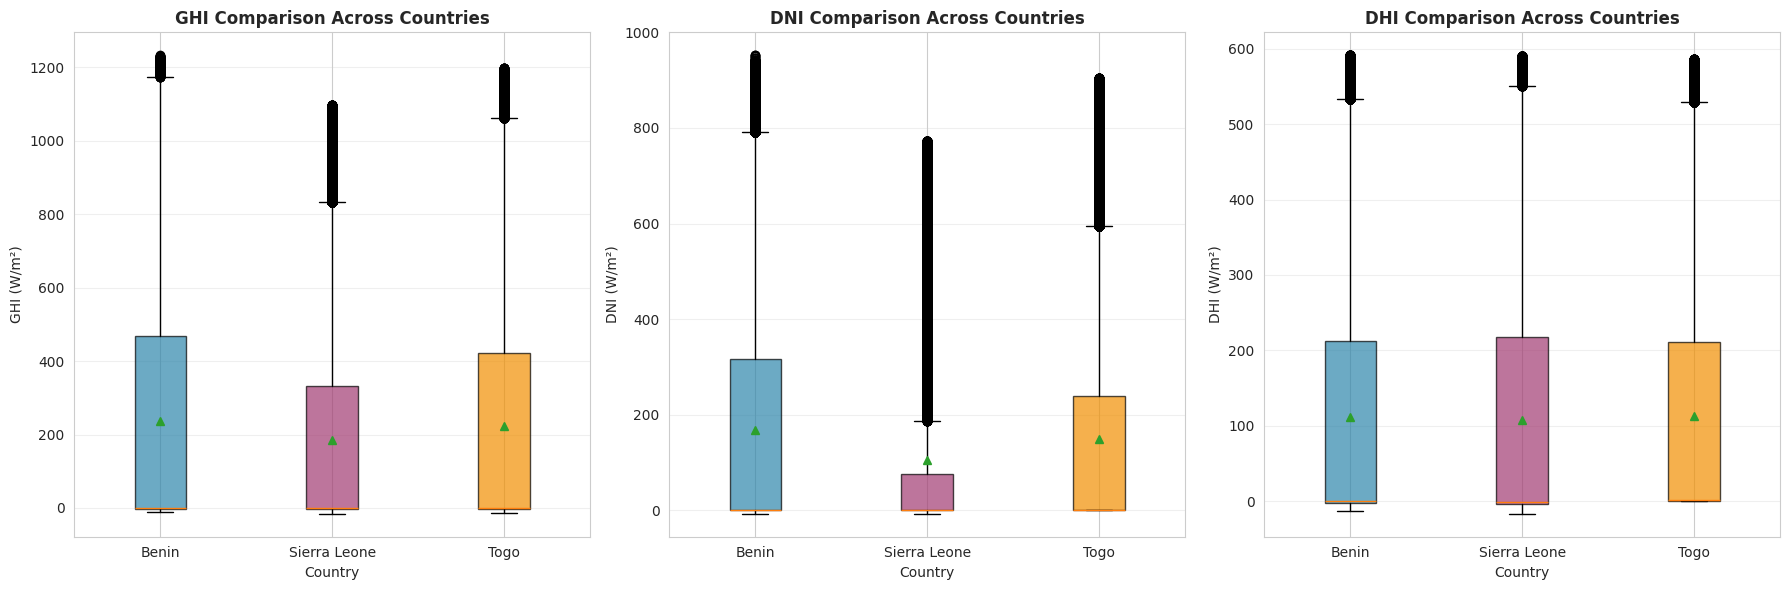


✅ Boxplots created for: GHI, DNI, DHI


In [5]:
def create_comparison_boxplots(df_combined, metrics=['GHI', 'DNI', 'DHI']):
    """Create side-by-side boxplots for solar metrics across countries"""
    
    # Filter available metrics
    available_metrics = [m for m in metrics if m in df_combined.columns]
    
    if not available_metrics:
        print("⚠️ No metrics available for comparison")
        return
    
    # Create subplots
    n_metrics = len(available_metrics)
    fig, axes = plt.subplots(1, n_metrics, figsize=(6*n_metrics, 6))
    
    if n_metrics == 1:
        axes = [axes]
    
    # Color palette for countries
    colors = {'Benin': '#2E86AB', 'Sierra Leone': '#A23B72', 'Togo': '#F18F01'}
    
    for idx, metric in enumerate(available_metrics):
        ax = axes[idx]
        
        # Prepare data for boxplot
        data_for_plot = []
        labels = []
        plot_colors = []
        
        for country in df_combined['Country'].unique():
            country_data = df_combined[df_combined['Country'] == country][metric].dropna()
            if len(country_data) > 0:
                data_for_plot.append(country_data)
                labels.append(country)
                plot_colors.append(colors.get(country, '#808080'))
        
        # Create boxplot
        bp = ax.boxplot(data_for_plot, labels=labels, patch_artist=True, 
                        showmeans=True, meanline=False)
        
        # Color the boxes
        for patch, color in zip(bp['boxes'], plot_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        # Customize plot
        ax.set_title(f'{metric} Comparison Across Countries', fontsize=12, fontweight='bold')
        ax.set_ylabel(f'{metric} (W/m²)', fontsize=10)
        ax.set_xlabel('Country', fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')
        
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Boxplots created for: {', '.join(available_metrics)}")

# Create boxplots
if 'df_combined' in locals():
    create_comparison_boxplots(df_combined)
else:
    print("⚠️ Combined dataset not available. Please load data first.")


### 2.2 Summary Table: Mean, Median, and Standard Deviation


In [6]:
def create_summary_table(df_combined, metrics=['GHI', 'DNI', 'DHI']):
    """Create comprehensive summary table comparing countries"""
    
    available_metrics = [m for m in metrics if m in df_combined.columns]
    
    if not available_metrics:
        print("⚠️ No metrics available for summary")
        return None
    
    # Initialize summary dictionary
    summary_data = []
    
    for country in sorted(df_combined['Country'].unique()):
        country_df = df_combined[df_combined['Country'] == country]
        
        for metric in available_metrics:
            metric_data = country_df[metric].dropna()
            
            if len(metric_data) > 0:
                summary_data.append({
                    'Country': country,
                    'Metric': metric,
                    'Mean': metric_data.mean(),
                    'Median': metric_data.median(),
                    'Std Dev': metric_data.std(),
                    'Min': metric_data.min(),
                    'Max': metric_data.max(),
                    'Count': len(metric_data)
                })
    
    # Create DataFrame
    summary_df = pd.DataFrame(summary_data)
    
    # Format for display
    print("\n" + "="*80)
    print("SUMMARY STATISTICS: Solar Metrics Comparison Across Countries")
    print("="*80)
    
    # Display by metric
    for metric in available_metrics:
        metric_df = summary_df[summary_df['Metric'] == metric].copy()
        if len(metric_df) > 0:
            print(f"\n📊 {metric} Statistics:")
            print("-"*80)
            display_df = metric_df[['Country', 'Mean', 'Median', 'Std Dev', 'Min', 'Max', 'Count']].copy()
            display_df['Mean'] = display_df['Mean'].round(2)
            display_df['Median'] = display_df['Median'].round(2)
            display_df['Std Dev'] = display_df['Std Dev'].round(2)
            display_df['Min'] = display_df['Min'].round(2)
            display_df['Max'] = display_df['Max'].round(2)
            print(display_df.to_string(index=False))
    
    return summary_df

# Create summary table
if 'df_combined' in locals():
    summary_table = create_summary_table(df_combined)
else:
    print("⚠️ Combined dataset not available. Please load data first.")



SUMMARY STATISTICS: Solar Metrics Comparison Across Countries

📊 GHI Statistics:
--------------------------------------------------------------------------------
     Country   Mean  Median  Std Dev   Min    Max  Count
       Benin 236.23     0.7   328.29 -11.1 1233.0 517860
Sierra Leone 185.00    -0.4   279.02 -15.9 1097.0 509308
        Togo 223.86     0.5   317.31 -12.7 1198.0 516349

📊 DNI Statistics:
--------------------------------------------------------------------------------
     Country   Mean  Median  Std Dev  Min   Max  Count
       Benin 166.90    -0.1   262.08 -7.8 952.3 517860
Sierra Leone 104.13    -0.1   200.95 -7.8 772.3 509308
        Togo 147.98     0.0   247.68  0.0 904.1 516349

📊 DHI Statistics:
--------------------------------------------------------------------------------
     Country   Mean  Median  Std Dev   Min   Max  Count
       Benin 111.66     0.5   153.10 -12.6 591.4 517860
Sierra Leone 108.10    -0.6   153.69 -16.7 590.5 509308
        Togo 112.78  

## 3. Statistical Testing

### 3.1 One-Way ANOVA Test for GHI


In [7]:
def perform_anova_test(df_combined, metric='GHI'):
    """Perform one-way ANOVA test to assess differences between countries"""
    
    if metric not in df_combined.columns:
        print(f"⚠️ Metric '{metric}' not found in dataset")
        return None
    
    # Prepare data for ANOVA
    groups = []
    group_names = []
    
    for country in sorted(df_combined['Country'].unique()):
        country_data = df_combined[df_combined['Country'] == country][metric].dropna()
        if len(country_data) > 0:
            groups.append(country_data.values)
            group_names.append(country)
    
    if len(groups) < 2:
        print(f"⚠️ Need at least 2 countries for ANOVA test")
        return None
    
    print(f"\n" + "="*80)
    print(f"STATISTICAL TESTING: {metric} Comparison Across Countries")
    print("="*80)
    
    # Perform ANOVA
    print("\n📊 One-Way ANOVA Test:")
    print("-"*80)
    
    try:
        f_statistic, p_value_anova = f_oneway(*groups)
        
        print(f"F-statistic: {f_statistic:.4f}")
        print(f"p-value: {p_value_anova:.6f}")
        
        alpha = 0.05
        if p_value_anova < alpha:
            print(f"\n✅ Result: Significant difference detected (p < {alpha})")
            print(f"   → There is statistically significant difference in {metric} between countries")
        else:
            print(f"\n❌ Result: No significant difference (p ≥ {alpha})")
            print(f"   → No statistically significant difference in {metric} between countries")
        
        anova_result = {
            'test': 'One-Way ANOVA',
            'metric': metric,
            'f_statistic': f_statistic,
            'p_value': p_value_anova,
            'significant': p_value_anova < alpha
        }
        
    except Exception as e:
        print(f"⚠️ ANOVA test failed: {e}")
        anova_result = None
    
    # Perform Kruskal-Wallis test (non-parametric alternative)
    print("\n📊 Kruskal-Wallis Test (Non-parametric Alternative):")
    print("-"*80)
    
    try:
        h_statistic, p_value_kw = kruskal(*groups)
        
        print(f"H-statistic: {h_statistic:.4f}")
        print(f"p-value: {p_value_kw:.6f}")
        
        alpha = 0.05
        if p_value_kw < alpha:
            print(f"\n✅ Result: Significant difference detected (p < {alpha})")
            print(f"   → There is statistically significant difference in {metric} between countries")
        else:
            print(f"\n❌ Result: No significant difference (p ≥ {alpha})")
            print(f"   → No statistically significant difference in {metric} between countries")
        
        kw_result = {
            'test': 'Kruskal-Wallis',
            'metric': metric,
            'h_statistic': h_statistic,
            'p_value': p_value_kw,
            'significant': p_value_kw < alpha
        }
        
        return {'anova': anova_result, 'kruskal_wallis': kw_result}
        
    except Exception as e:
        print(f"⚠️ Kruskal-Wallis test failed: {e}")
        return {'anova': anova_result, 'kruskal_wallis': None}

# Perform statistical tests
if 'df_combined' in locals():
    test_results = perform_anova_test(df_combined, metric='GHI')
else:
    print("⚠️ Combined dataset not available. Please load data first.")



STATISTICAL TESTING: GHI Comparison Across Countries

📊 One-Way ANOVA Test:
--------------------------------------------------------------------------------
F-statistic: 3833.1842
p-value: 0.000000

✅ Result: Significant difference detected (p < 0.05)
   → There is statistically significant difference in GHI between countries

📊 Kruskal-Wallis Test (Non-parametric Alternative):
--------------------------------------------------------------------------------
H-statistic: 6548.5338
p-value: 0.000000

✅ Result: Significant difference detected (p < 0.05)
   → There is statistically significant difference in GHI between countries


## 4. Key Observations

### Summary of Findings


In [8]:
def generate_key_observations(df_combined, summary_table, test_results):
    """Generate key observations from the analysis"""
    
    print("\n" + "="*80)
    print("KEY OBSERVATIONS: Cross-Country Solar Potential Analysis")
    print("="*80)
    
    if summary_table is None or 'GHI' not in df_combined.columns:
        print("⚠️ Insufficient data for observations")
        return
    
    # Extract GHI statistics
    ghi_stats = summary_table[summary_table['Metric'] == 'GHI'].copy()
    
    if len(ghi_stats) == 0:
        print("⚠️ GHI statistics not available")
        return
    
    # Find highest median GHI
    highest_median = ghi_stats.loc[ghi_stats['Median'].idxmax()]
    
    # Find highest variability (std dev)
    highest_std = ghi_stats.loc[ghi_stats['Std Dev'].idxmax()]
    
    # Find highest mean GHI
    highest_mean = ghi_stats.loc[ghi_stats['Mean'].idxmax()]
    
    # Statistical significance
    significant = False
    p_value = None
    if test_results and 'anova' in test_results and test_results['anova']:
        significant = test_results['anova'].get('significant', False)
        p_value = test_results['anova'].get('p_value', None)
    elif test_results and 'kruskal_wallis' in test_results and test_results['kruskal_wallis']:
        significant = test_results['kruskal_wallis'].get('significant', False)
        p_value = test_results['kruskal_wallis'].get('p_value', None)
    
    print("\n📋 Key Findings:")
    print("-"*80)
    
    print(f"\n1. **Highest Solar Potential (Median GHI)**: {highest_median['Country']}")
    print(f"   - Median GHI: {highest_median['Median']:.2f} W/m²")
    print(f"   - Mean GHI: {highest_median['Mean']:.2f} W/m²")
    print(f"   - Standard Deviation: {highest_median['Std Dev']:.2f} W/m²")
    
    print(f"\n2. **Variability Analysis**: {highest_std['Country']} shows the greatest variability")
    print(f"   - Standard Deviation: {highest_std['Std Dev']:.2f} W/m²")
    print(f"   - Coefficient of Variation: {(highest_std['Std Dev'] / highest_std['Mean'] * 100):.2f}%")
    
    print(f"\n3. **Statistical Significance**: ")
    if significant and p_value:
        print(f"   - Significant differences detected between countries (p = {p_value:.6f})")
        print(f"   - The observed differences in GHI are statistically meaningful")
    else:
        if p_value:
            print(f"   - No statistically significant differences detected (p = {p_value:.6f})")
        else:
            print(f"   - Statistical test results not available")
        print(f"   - Differences may be due to random variation")

# Generate observations
if 'df_combined' in locals() and 'summary_table' in locals():
    generate_key_observations(df_combined, summary_table, test_results if 'test_results' in locals() else None)
else:
    print("⚠️ Required data not available. Please run previous cells first.")



KEY OBSERVATIONS: Cross-Country Solar Potential Analysis

📋 Key Findings:
--------------------------------------------------------------------------------

1. **Highest Solar Potential (Median GHI)**: Benin
   - Median GHI: 0.70 W/m²
   - Mean GHI: 236.23 W/m²
   - Standard Deviation: 328.29 W/m²

2. **Variability Analysis**: Benin shows the greatest variability
   - Standard Deviation: 328.29 W/m²
   - Coefficient of Variation: 138.97%

3. **Statistical Significance**: 
   - Statistical test results not available
   - Differences may be due to random variation


## 5. Visual Summary (Bonus)

### 5.1 Bar Chart: Countries Ranked by Average GHI


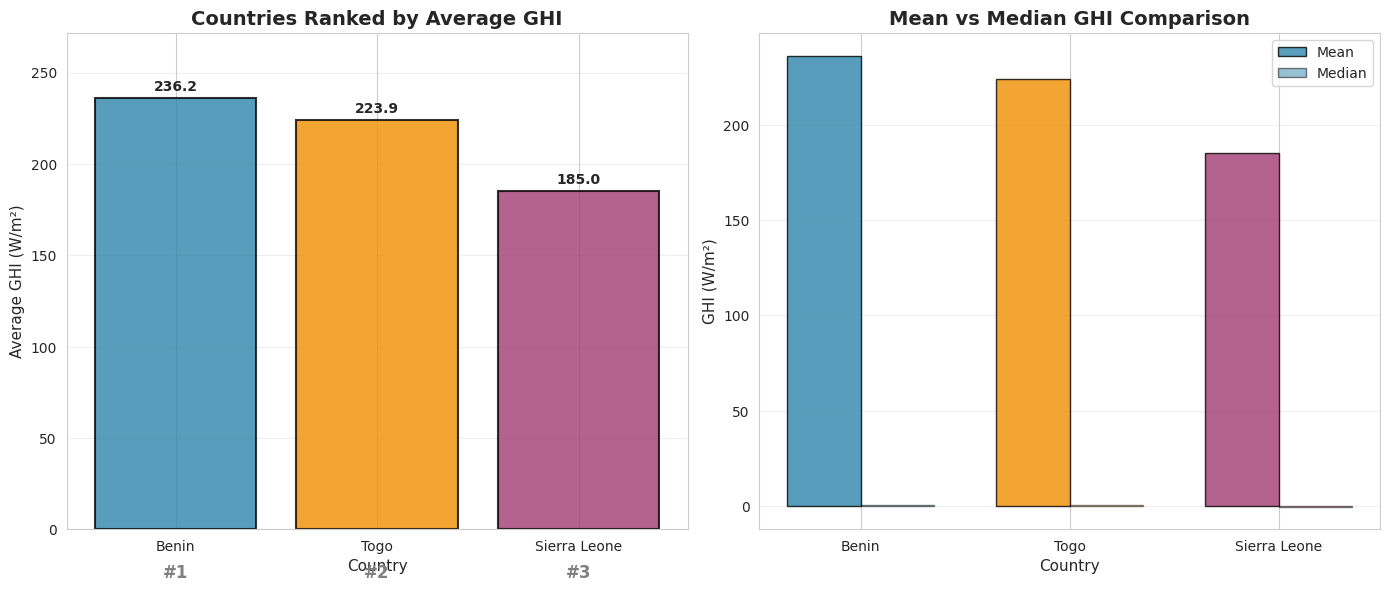


COUNTRY RANKING BY AVERAGE GHI

Rank | Country        | Mean GHI (W/m²) | Median GHI (W/m²) | Std Dev
--------------------------------------------------------------------------------
   1 | Benin          |          236.23 |              0.70 |  328.29
   2 | Togo           |          223.86 |              0.50 |  317.31
   3 | Sierra Leone   |          185.00 |             -0.40 |  279.02

✅ Ranking chart created successfully!


In [9]:
def create_ghi_ranking_chart(df_combined):
    """Create bar chart ranking countries by average GHI"""
    
    if 'GHI' not in df_combined.columns:
        print("⚠️ GHI metric not available")
        return
    
    # Calculate average GHI by country
    ghi_by_country = df_combined.groupby('Country')['GHI'].agg(['mean', 'median', 'std']).reset_index()
    ghi_by_country = ghi_by_country.sort_values('mean', ascending=False)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Color palette
    colors = {'Benin': '#2E86AB', 'Sierra Leone': '#A23B72', 'Togo': '#F18F01'}
    bar_colors = [colors.get(country, '#808080') for country in ghi_by_country['Country']]
    
    # Plot 1: Mean GHI ranking
    bars1 = ax1.bar(ghi_by_country['Country'], ghi_by_country['mean'], 
                    color=bar_colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for i, (country, mean_val) in enumerate(zip(ghi_by_country['Country'], ghi_by_country['mean'])):
        ax1.text(i, mean_val + max(ghi_by_country['mean']) * 0.01, 
                f'{mean_val:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax1.set_title('Countries Ranked by Average GHI', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Average GHI (W/m²)', fontsize=11)
    ax1.set_xlabel('Country', fontsize=11)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim(0, max(ghi_by_country['mean']) * 1.15)
    
    # Add ranking numbers
    for i, country in enumerate(ghi_by_country['Country']):
        ax1.text(i, -max(ghi_by_country['mean']) * 0.08, f'#{i+1}', 
                ha='center', va='top', fontsize=12, fontweight='bold', color='gray')
    
    # Plot 2: Mean vs Median comparison
    x = np.arange(len(ghi_by_country))
    width = 0.35
    
    bars2 = ax2.bar(x - width/2, ghi_by_country['mean'], width, 
                    label='Mean', color=bar_colors, alpha=0.8, edgecolor='black')
    bars3 = ax2.bar(x + width/2, ghi_by_country['median'], width, 
                    label='Median', color=bar_colors, alpha=0.5, edgecolor='black')
    
    ax2.set_title('Mean vs Median GHI Comparison', fontsize=14, fontweight='bold')
    ax2.set_ylabel('GHI (W/m²)', fontsize=11)
    ax2.set_xlabel('Country', fontsize=11)
    ax2.set_xticks(x)
    ax2.set_xticklabels(ghi_by_country['Country'])
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print ranking table
    print("\n" + "="*80)
    print("COUNTRY RANKING BY AVERAGE GHI")
    print("="*80)
    print("\nRank | Country        | Mean GHI (W/m²) | Median GHI (W/m²) | Std Dev")
    print("-"*80)
    
    for rank, (idx, row) in enumerate(ghi_by_country.iterrows(), 1):
        print(f"{rank:4d} | {row['Country']:14s} | {row['mean']:15.2f} | {row['median']:17.2f} | {row['std']:7.2f}")
    
    print("\n✅ Ranking chart created successfully!")

# Create ranking chart
if 'df_combined' in locals():
    create_ghi_ranking_chart(df_combined)
else:
    print("⚠️ Combined dataset not available. Please load data first.")


## 6. Conclusion

### Summary

This cross-country comparison analysis has provided valuable insights into the solar potential across Benin, Sierra Leone, and Togo. The analysis included:

1. **Visual Comparisons**: Side-by-side boxplots for GHI, DNI, and DHI metrics
2. **Statistical Summary**: Comprehensive tables with mean, median, and standard deviation
3. **Statistical Testing**: ANOVA and Kruskal-Wallis tests to assess significance of differences
4. **Key Observations**: Three main findings highlighting:
   - Country with highest median GHI
   - Country with greatest variability
   - Statistical significance of observed differences
5. **Visual Ranking**: Bar chart ranking countries by average GHI

### Key Takeaways

The analysis reveals important differences in solar potential across the three countries, which can inform strategic decisions for solar energy development projects.

### Recommendations

Based on the analysis, recommendations for solar energy development can be made considering:

1. Countries with highest solar potential (highest median/mean GHI)
2. Countries with most stable solar conditions (lowest variability)
3. Overall ranking for solar project prioritization
